In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pylab as plt
# %matplotlib tk
# %matplotlib nbagg
# %matplotlib inline
import h5py
import json
import glob
import socket
import os

# Loading files

In [3]:
hostname = socket.gethostname()
if hostname == 'HAITI' or 'Gorleben':
    DIR = "C:/Users/xin/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "D:/xin/datasets/Trelleborg/2021-01-27-V24/*/*.h5"
if hostname == 'BALI':
    DIR = "/home/xin/projects/trelleborg"
    DATASET = "/storage/xin/datasets/Trelleborg/2021-01-27-V24/*/*.h5"
if hostname == 'LAPTOP-1FOJITEG':
    DIR = "C:/Users/xinch/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "C:/LINHC/VersucheDBs/Trelleborg/2021-01-27-V24/*/*.h5"
DIR = os.path.abspath(DIR)
DATASET = os.path.abspath(DATASET)

file_list = []
for file in glob.glob(DATASET):
    file_list.append(file)
file_list 

['C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\2_Phase_A-D\\20210127_Phase_A-D_LEM1.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\2_Phase_A-D\\20210127_Phase_A-D_LEM2.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\3_Phase_B-E\\20210201_3_Phase_B-E_LEM1.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\3_Phase_B-E\\20210201_3_Phase_B-E_LEM2.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\4_Phase_C-F\\20210202_4_Phase_C-F_LEM1.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\4_Phase_C-F\\20210202_4_Phase_C-F_LEM2.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\5_Phase_A-D\\20210218_5_Phase_A-D_LEM1.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\5_Phase_A-D\\20210218_5_Phase_A-D_LEM2.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\7_Phase_C-F\\20210218_7_Phase_C-F_LEM1.h5',
 'C:\\LINHC\\VersucheDBs\\Trelleborg\\2021-01-27-V24\\7_Phase_C-F\\20210218_7_Phase_C-F_LEM2.h5',
 'C:\\LINHC\\VersucheDBs

In [4]:
file = file_list[0]
filename = file.split(os.sep)[-1][:-3]

h51 = h5py.File(file, "r")

print("ATTR:")
print(h51.attrs.keys())

print("Keys:")
print(h51.keys())

# frequency index
fidx = 20

ATTR:
<KeysViewHDF5 ['name_lookup', 'name_rev_lookup']>
Keys:
<KeysViewHDF5 ['S11_LEM1', 'S21_P1_LEM1', 'S21_P2_LEM1', 'S22_LEM1', 'hub1', 'hub2', 'ip1k1', 'ip1k2', 'ip2k1', 'ip2k2', 'k1at', 'k1f', 'k1p', 'k1t', 'k2at', 'k2f', 'k2p', 'k2t', 'phi', 'pos1', 'pos2', 'shub1', 'shub2', 'sk1at', 'sk1f', 'sk1p', 'sk1t', 'sk2at', 'sk2f', 'sk2p', 'sk2t', 'spd1', 'spd2', 'sphi', 'spos1', 'spos2', 'sspd1', 'sspd2', 'stdf', 't', 'tdf']>


In [3]:
# json.loads(h51.attrs["name_lookup"])

# Find the low speed areas

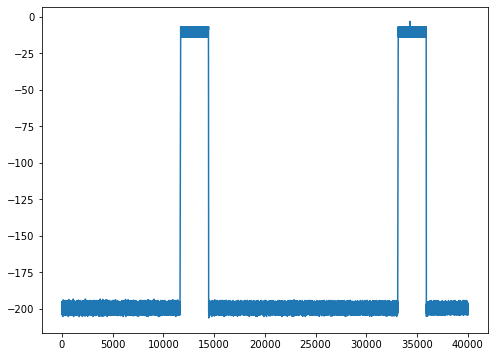

In [4]:
%matplotlib inline
plt.figure(figsize=(8,6))
# plt.plot(h51['pos1'][-40000:])
plt.plot(h51['spd1'][:40000])

all low speed areas (low)

In [5]:
low = h51['spd1'][:]>-50
pos_low = h51['pos1'][low]
s21_low = h51['S21_P1_LEM1'][low,fidx]

all low speed areas as ONE sequence

In [6]:
low = np.where(h51['spd1'][:]>-50)[0]
pos_low = h51['pos1'][low]
s21_low = h51['S21_P1_LEM1'][low,fidx]

all low speed areas as seperate arrays

In [7]:
low_sep = np.where(np.diff(low)>10000)[0]
pos_low_sep = np.split(pos_low,low_sep+1)
s21_low_sep = np.split(s21_low,low_sep+1)

cut out some points to make sure all points in low speed 
(if not some points in high speed area will showed up in s21, especially in later timestamps)

In [8]:
# # may not be necessary if we only use points BETWEEN each peak values in an interval, see below
# low_sep_safe=[]
# for i in low_sep:
#     low_sep_safe.append(i-500)
#     low_sep_safe.append(i+500)
# pos_low_sep_safe_ = np.split(pos_low,low_sep_safe)
# s21_low_sep_safe_ = np.split(s21_low,low_sep_safe)

# pos_low_sep_safe=[pos_low_sep_safe_[i] for i in range(0, len(pos_low_sep_safe_),2)]
# pos_low_safe = np.concatenate(pos_low_sep_safe)
# s21_low_sep_safe=[s21_low_sep_safe_[i] for i in range(0, len(s21_low_sep_safe_),2)]
# s21_low_safe = np.concatenate(s21_low_sep_safe)

find the max values of positions in each low speed interval

In [8]:
# create a list of arrays max_sep, each array contains peak values of the corresponding low speed area.
max_sep = [] # (46,4)
for k in range(len(pos_low_sep)):
    # temporary sequency ts
    ts = pos_low_sep[k] 

    # find top 30 highest values
    max_20 = np.argsort(ts)[-30:][::-1]

    # filter the max value for each period
    temp =[max_20[0]]
    for i in max_20:
        if all([abs(j-i)>50 for j in temp]):        
            temp.append(i)
    max_sep.append(np.sort(temp))
    
# There should be 4 max values in each interval
assert all([len(max_sep[i])==4 for i in range(len(max_sep))]) 

separate each interval into 3 periods (between 4 max values)

In [9]:
# create a list of lists of arrays pos_low_sep_int / s21_low_sep_int. 
# Each inner list corresponds to a low speed area and contiains position / s21 arrays separated by peak values 

pos_low_sep_int = [] # (46,3, number of ponits in one peroid)
s21_low_sep_int = []

for i in range(len(pos_low_sep)):
    
    # only keep the points between max values because points at the beginning or end may be in high speed area
    temp = np.split(pos_low_sep[i],max_sep[i])
    pos_low_sep_int.append(temp[1:-1]) 
    
    temp2 = np.split(s21_low_sep[i],max_sep[i])
    s21_low_sep_int.append(temp2[1:-1])
    
# 3 periods chosen in each interval 
assert all([len(s21_low_sep_int[i])==3 for i in range(len(max_sep))]) 

In [14]:
len (s21_low_sep_int[0])

3

### Quick check

In [10]:
s21_low_safe.shape

(82635,)

In [ ]:
%matplotlib nbagg
plt.plot(abs(s21_low),'.')

<IPython.core.display.Javascript object>


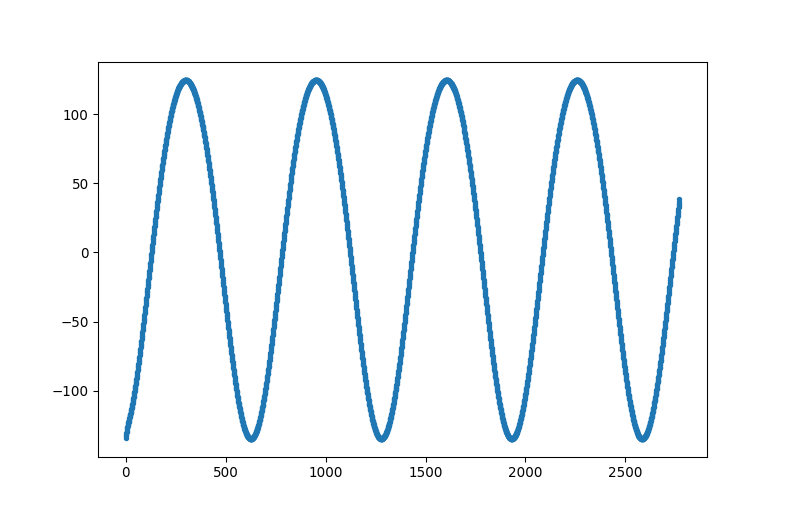

In [71]:
%matplotlib nbagg
plt.plot(pos_low_sep[40],'.')

In [27]:
%matplotlib nbagg
plt.plot(abs(s21_low_safe),'.')

<IPython.core.display.Javascript object>

In [122]:
%matplotlib nbagg
plt.plot(abs(s21_low_sep_int[0][0]),'.')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


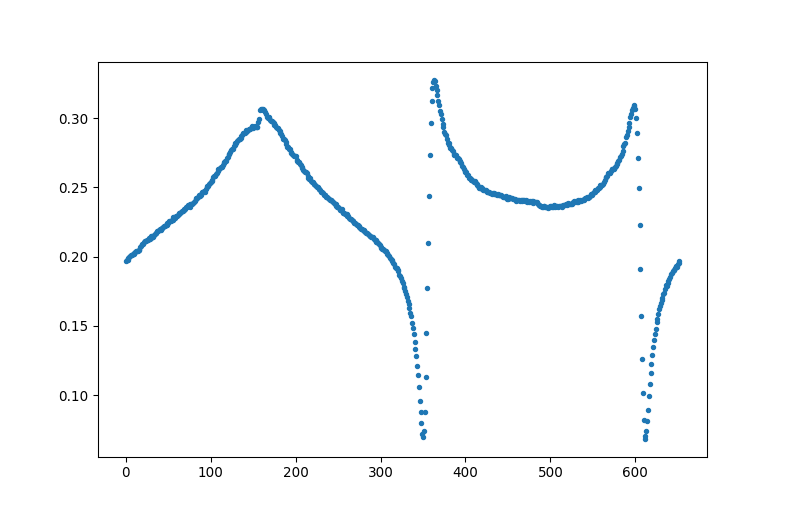

In [124]:
%matplotlib nbagg
plt.plot(abs(s21_low_sep_int[20][0]),'.')

<IPython.core.display.Javascript object>


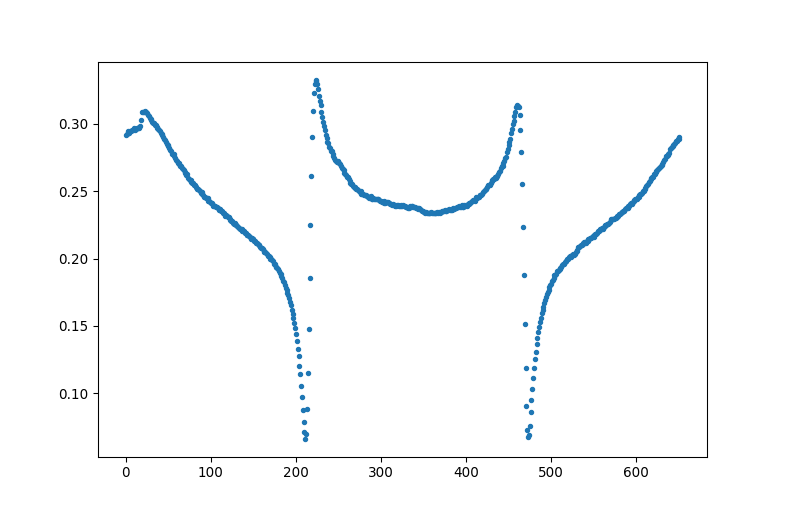

In [123]:
%matplotlib nbagg
plt.plot(abs(s21_low_sep_int[40][0]),'.')

## Preprocessing for DTW

In [28]:
# # abs, minus avg and scaling

# pos_low_norm = (pos_low - np.mean(pos_low))/1000
# s21_low_norm = abs(s21_low) - np.mean(abs(s21_low))

# pos_low_safe_norm = (pos_low_safe - np.mean(pos_low_safe))/1000
# s21_low_safe_norm = abs(s21_low_safe) - np.mean(abs(s21_low_safe))

In [ ]:
# def ...

## DTW LVL

LVL means low speed area vs low speed area.
i.e. all periods in an low speed area are concatenated to ONE sequence and compared to each other

In [15]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

In [65]:
s1 = abs(np.concatenate(s21_low_sep_int[0]))
s2 = abs(np.concatenate(s21_low_sep_int[1]))

path = dtw.warping_path(s1, s2)
delta_L1VL2 = round(np.mean([pair[0]-pair[1] for pair in path]))
delta_L1VL2

5

<IPython.core.display.Javascript object>


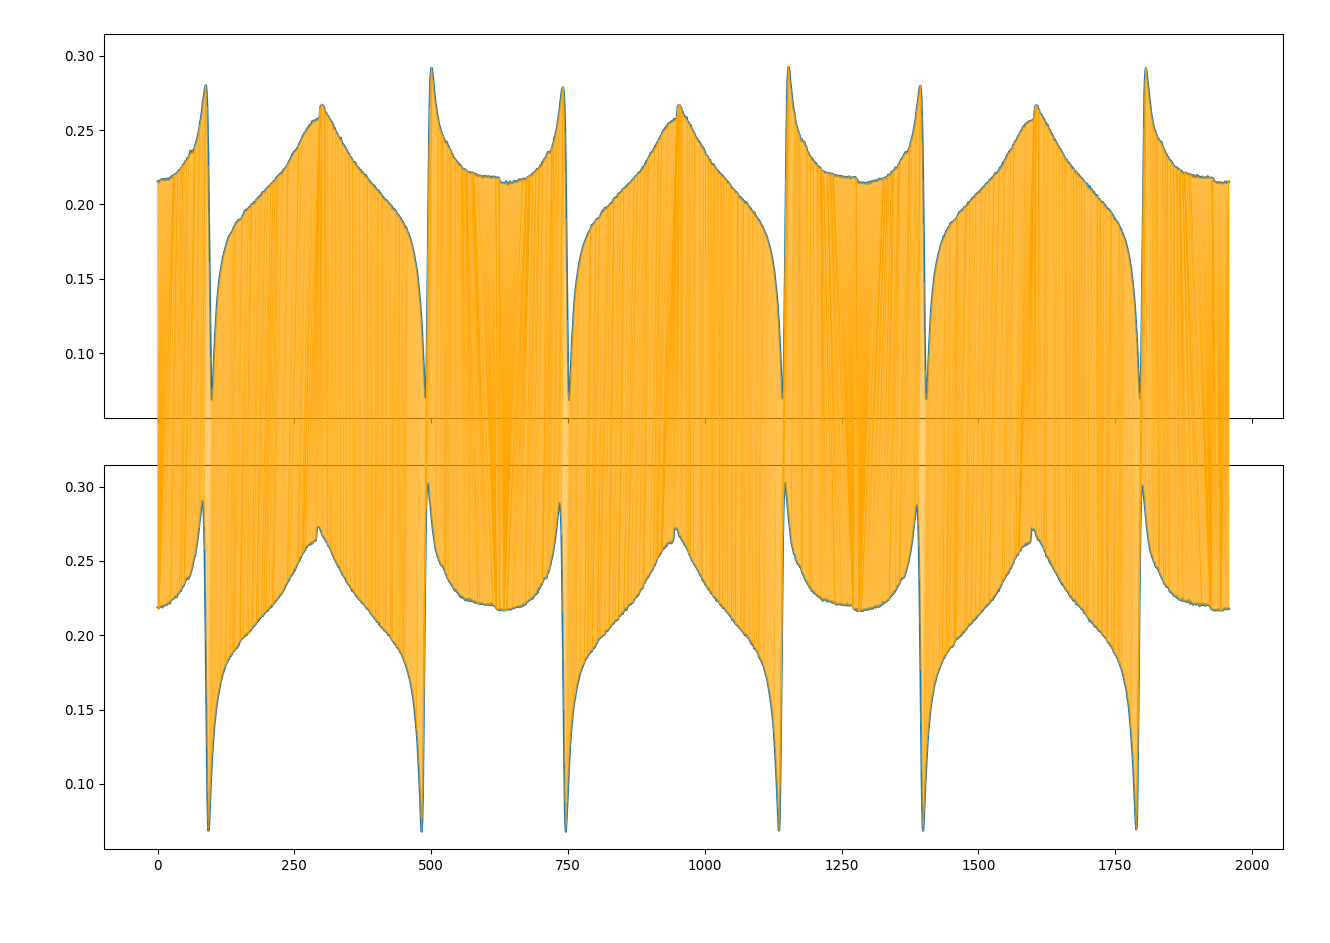

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [21]:
%matplotlib nbagg
dtwvis.plot_warping(s1, s2, path)

In [28]:
s3 = abs(np.concatenate(s21_low_sep_int[2]))

path = dtw.warping_path(s1, s3)
delta_L1VL3 = round(np.mean([pair[0]-pair[1] for pair in path]))
delta_L1VL3

7

In [29]:
path = dtw.warping_path(s2, s3)
delta_L2VL3 = round(np.mean([pair[0]-pair[1] for pair in path]))
delta_L2VL3

1

## Results LVL

In [ ]:
Ls = np.append(low[low_sep],low[-1])
print("timestamps of Ls:")
print (Ls)

Fs = np.append(low[0],low[low_sep+1])
print("timestamps of Fs:")
print (Fs)

print("Durations of lsa:\n",Ls-Fs)

In [119]:
# Ls = low[low_sep]
# print("timestamps of Ls:")
# print (Ls)

# print ("interval duration:")
# print(np.diff(low_sep))

# Fs = Ls-np.append(low[low_sep][0]-low[0],np.diff(low_sep))
# print("timestamps of Fs:")
# print (Fs)

timestamps of Ls:
[ 14443  35899  57359  78815 100274 121732 143192 164649 186106 207561
 229019 250475 271931 293390 314847 336304 357760 379214 400670 422129
 443587 465047 486506 507966 529422 550879 572338 593794 615254 636714
 658168 679621 701081 722537 743992 765451 786909 808367 829825 851284
 872738 894197 915655 937110 958570]
interval duration:
[2774 2777 2773 2777 2776 2777 2774 2774 2772 2775 2774 2773 2776 2775
 2775 2774 2771 2774 2776 2775 2777 2776 2778 2773 2774 2776 2773 2777
 2777 2771 2770 2777 2774 2772 2776 2775 2775 2776 2776 2772 2776 2776
 2772 2777]
timestamps of Fs:
[ 11670  33125  54582  76042  97497 118956 140415 161875 183332 204789
 226244 247701 269158 290614 312072 333529 354986 376443 397896 419353
 440812 462270 483730 505188 526649 548105 569562 591021 612477 633937
 655397 676851 698304 719763 741220 762675 784134 805592 827049 848508
 869966 891421 912879 934338 955793]


In [34]:
# low speed areas (Obtained by visual inspection of drawing)
F1 = 12000
L1 = 14000
SHIFT1_OPT = 31

F2 = 33500
L2 = 35500

F3 = 55000
L3 = 57000

In [35]:
def plot_p_s(pos,pos_shift,s21):
    
    """
    plot the scattering parameters with respect to postions at LAST
    """
    
    fig = plt.figure(figsize=(12,8))
    fig.suptitle('scattering parameters with respect to positions', fontsize=16)
    # original
    ax1 = plt.subplot(2,1,1)
    ax1.plot(pos,s21,'.',label='s21')
    ax1.title.set_text('original')
    ax1.legend
    
    # plots after shift
    ax2 = plt.subplot(2,1,2)
    ax2.plot(pos_shift,s21,'.',label='s21')
    ax2.title.set_text('after shift')
    ax2.legend

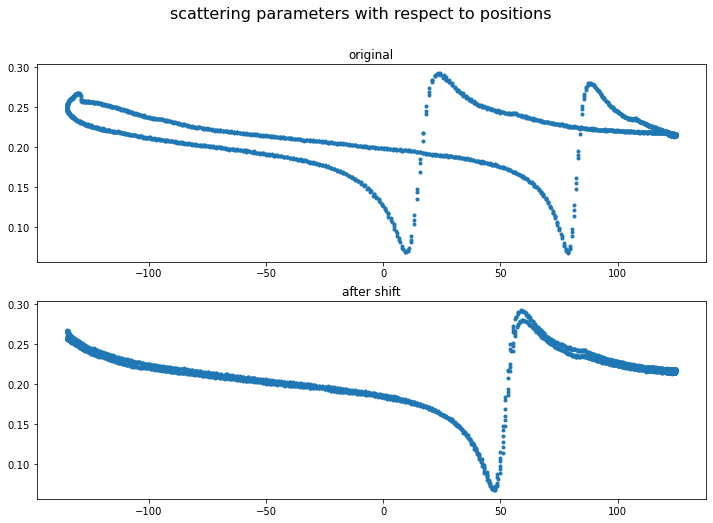

In [36]:
pos = h51['pos1'][F1:L1]
s21 = abs(h51['S21_P1_LEM1'][F1:L1,fidx])
pos_shift = h51['pos1'][F1+SHIFT1_OPT:L1+SHIFT1_OPT]

%matplotlib inline
plot_p_s(pos,pos_shift,s21)

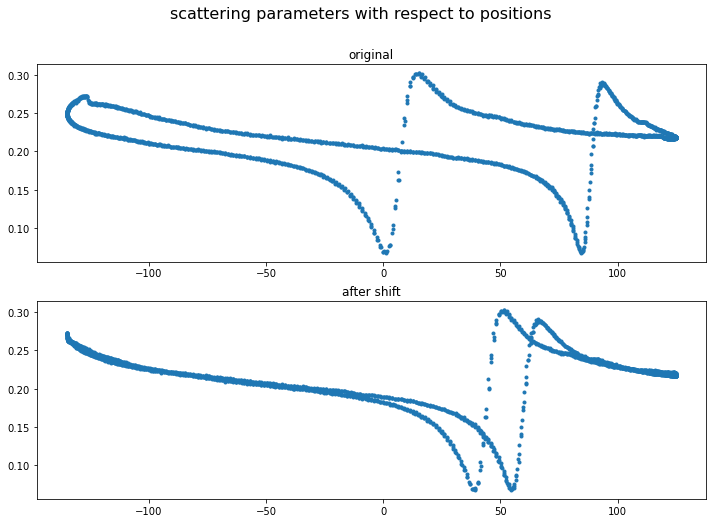

In [37]:
# plot the 2nd low speed area but using SHIFT1_OPT
pos = h51['pos1'][F2:L2]
s21 = abs(h51['S21_P1_LEM1'][F2:L2,fidx])
pos_shift = h51['pos1'][F2+SHIFT1_OPT:L2+SHIFT1_OPT]

%matplotlib inline
plot_p_s(pos,pos_shift,s21)

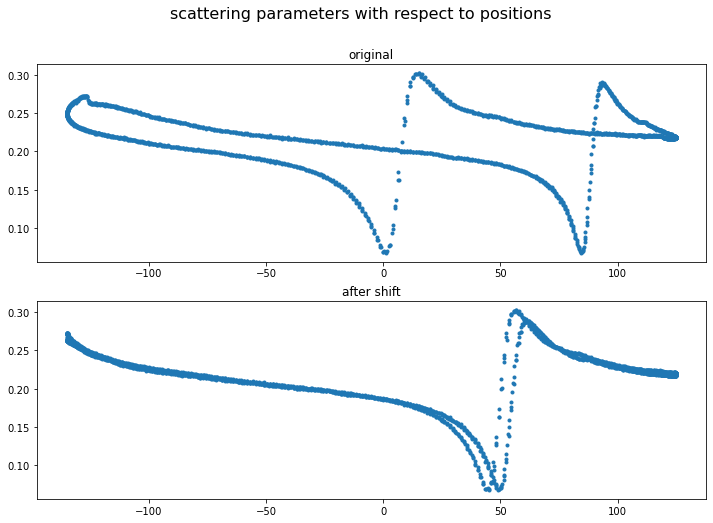

In [38]:
# plot the 2nd low speed area but using SHIFT2
SHIFT2 = SHIFT1_OPT + delta
pos = h51['pos1'][F2:L2]
s21 = abs(h51['S21_P1_LEM1'][F2:L2,fidx])
pos_shift = h51['pos1'][F2+SHIFT2:L2+SHIFT2]

%matplotlib inline
plot_p_s(pos,pos_shift,s21)

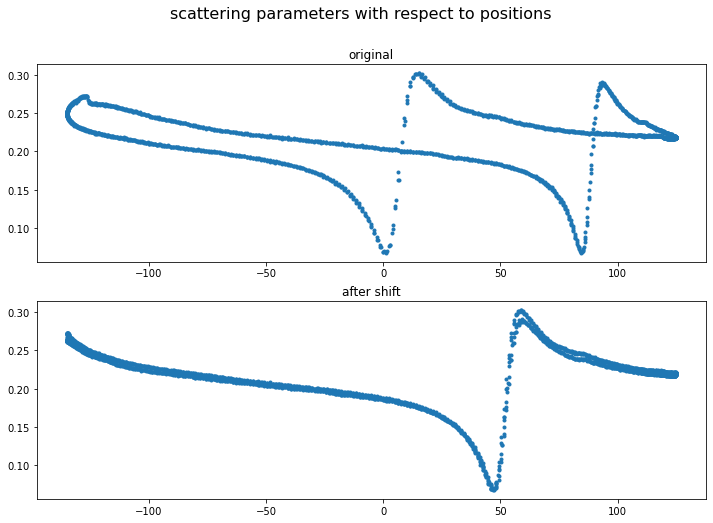

In [39]:
# plot the 2nd low speed area but using optimal SHIFT2_OPT
SHIFT2_OPT = SHIFT1 + delta +2
pos = h51['pos1'][F2:L2]
s21 = abs(h51['S21_P1_LEM1'][F2:L2,fidx])
pos_shift = h51['pos1'][F2+SHIFT2_OPT:L2+SHIFT2_OPT]

%matplotlib inline
plot_p_s(pos,pos_shift,s21)

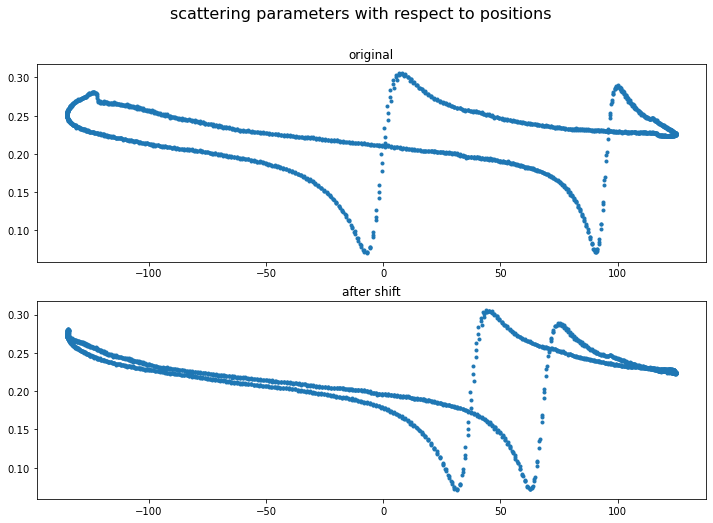

In [40]:
# plot the 3rd low speed area but using SHIFT1_OPT
pos = h51['pos1'][F3:L3]
s21 = abs(h51['S21_P1_LEM1'][F3:L3,fidx])
pos_shift = h51['pos1'][F3+SHIFT1_OPT:L3+SHIFT1_OPT]

%matplotlib inline
plot_p_s(pos,pos_shift,s21)

Current shift:  38


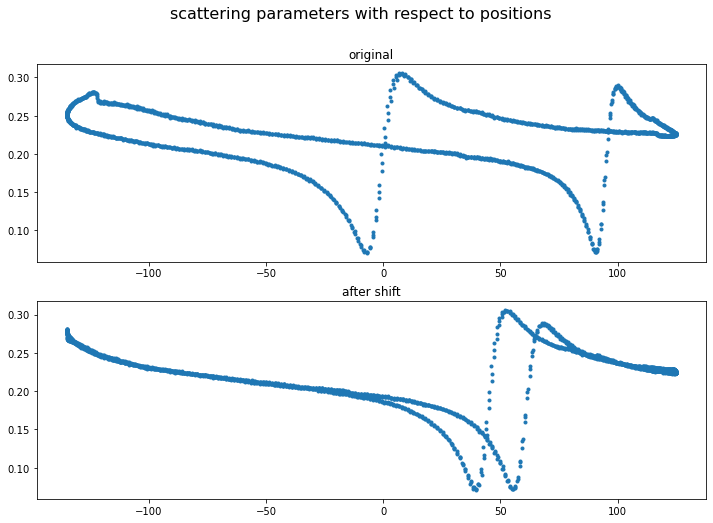

In [45]:
# plot the 3rd low speed area but using SHIFT3 calculated by s1 vs s3
SHIFT3 = SHIFT1 + delta_L1VL3
pos = h51['pos1'][F3:L3]
s21 = abs(h51['S21_P1_LEM1'][F3:L3,fidx])
pos_shift = h51['pos1'][F3+SHIFT3:L3+SHIFT3]

%matplotlib inline
plot_p_s(pos,pos_shift,s21)
print ("Current shift: ", SHIFT3)

Current shift:  37


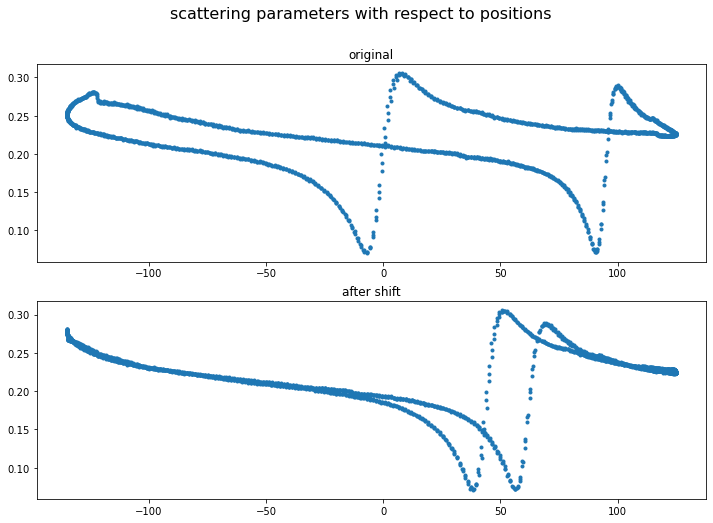

In [46]:
# plot the 3rd low speed area but using SHIFT3 calculated by s1 vs s2 and s2 vs s3 
SHIFT3 = SHIFT2+ delta_L2VL3
pos = h51['pos1'][F3:L3]
s21 = abs(h51['S21_P1_LEM1'][F3:L3,fidx])
pos_shift = h51['pos1'][F3+SHIFT3:L3+SHIFT3]

%matplotlib inline
plot_p_s(pos,pos_shift,s21)
print ("Current shift: ", SHIFT3)

Optimal shift:  45


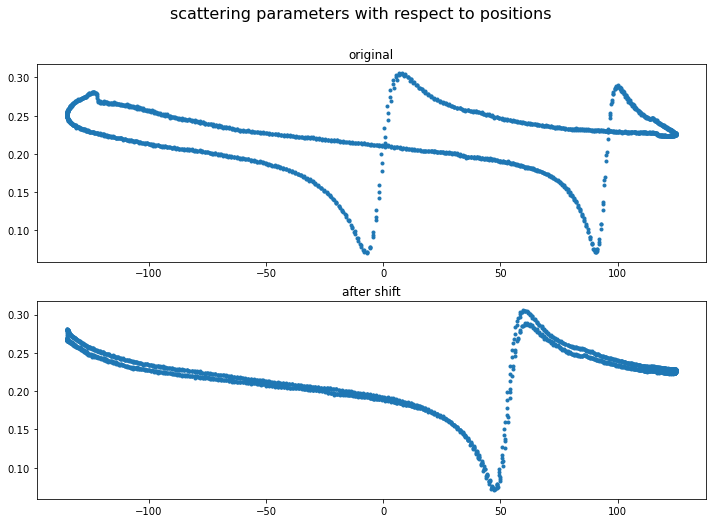

In [48]:
# plot the 3rd low speed area but using optimal shift
SHIFT3_OPT = SHIFT2 + delta_L2VL3 + 8
pos = h51['pos1'][F3:L3]
s21 = abs(h51['S21_P1_LEM1'][F3:L3,fidx])
pos_shift = h51['pos1'][F3+SHIFT3_OPT:L3+SHIFT3_OPT]

%matplotlib inline
plot_p_s(pos,pos_shift,s21)

print ("Optimal shift: ", SHIFT3_OPT)

# DTW PVP

PVP means period vs period.

i.e. Each period is considered as a sequence and compared to each other

In [108]:
paths_pvp = []
deltas_pvp = []
LAST = 10

for i in range (LAST):
    for j in range (3):
        if j !=2:
            paths_pvp.append(dtw.warping_path(abs(s21_low_sep_int[i][j]),abs(s21_low_sep_int[i][j+1])))
        if j == 2:
            paths_pvp.append(dtw.warping_path(abs(s21_low_sep_int[i][j]),abs(s21_low_sep_int[i+1][0])))

for path in paths_pvp:
    deltas_pvp.append(round(np.mean([pair[0]-pair[1] for pair in path])))

print(deltas_pvp)

[0, -1, 5, 0, 1, -2, 1, 0, 6, 0, 0, 1, 0, 0, 3, 2, 1, 7, 0, 1, 6, 1, 0, 4, 2, 1, 7, -1, 0, 8, -2, 0, 6]


### compare with LVL

In [95]:
def dtw_lvl(i,j):
    s1 = abs(np.concatenate(s21_low_sep_int[i]))
    s2 = abs(np.concatenate(s21_low_sep_int[j]))
    path = dtw.warping_path(s1,s2)
    delta = round(np.mean([pair[0]-pair[1] for pair in path]))
    return path, delta

In [96]:
paths_lvl = []
deltas_lvl = []
for i in range(10):
    path, delta = dtw_lvl (i,i+1)
    paths_lvl.append(path)
    deltas_lvl.append(delta)
deltas_lvl

[5, 1, 6, 5, 4, 9, 7, 5, 9, 8]

In [111]:
# convert deltas_pvp to make it comparable to deltas_lvl
deltas_pvptolvl=[]
_deltas_pvp = deltas_pvp[2:]
for i in range (len(_deltas_pvp)//3):
    deltas_pvptolvl.append(sum([_deltas_pvp.pop(0) for _ in range(3)]))
deltas_pvptolvl

[6, -1, 6, 1, 6, 8, 7, 7, 6, 6]

In [112]:
import pickle

dic ={
    "paths_lvl" : paths_lvl,
    "deltas_lvl" : deltas_lvl,
    "deltas_pvptolvl": deltas_pvptolvl,
    "paths_pvp" : paths_pvp,
    "deltas_pvp" : deltas_pvp  
}
pickle.dump(dic, open( "dtw.pickle", "wb" ) )

In [3]:
import pickle
saved_dic = pickle.load( open( "dtw.pickle", "rb" ) )

In [114]:
np.cumsum(deltas_pvptolvl)+SHIFT1_OPT

array([37, 36, 42, 43, 49, 57, 64, 71, 77, 83], dtype=int32)

In [118]:
shift_pvptolvl = np.append(SHIFT1_OPT,np.cumsum(deltas_pvptolvl)+SHIFT1_OPT)
shift_lvl =  np.append(SHIFT1_OPT,np.cumsum(deltas_lvl)+SHIFT1_OPT)
shift_pvp =  np.append(SHIFT1_OPT,np.cumsum(deltas_pvp)+SHIFT1_OPT)

In [125]:
F = Fs[10]+max_sep[10][0]
L = Fs[10]+max_sep[10][-1]
pos = h51['pos1'][F:L]
s21 = abs(h51['S21_P1_LEM1'][F:L,fidx])
pos_shift_lvl = h51['pos1'][F + shift_lvl[10] : L + shift_lvl[10]]
pos_shift_pvptolvl = h51['pos1'][F + shift_pvptolvl[10] : L + shift_pvptolvl[10]]
print(shift_lvl[10])

90


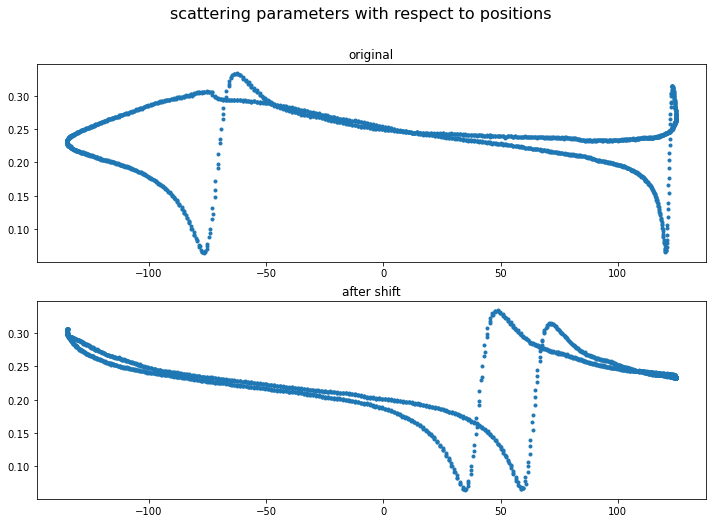

In [123]:
%matplotlib inline
plot_p_s(pos,pos_shift_lvl,s21)

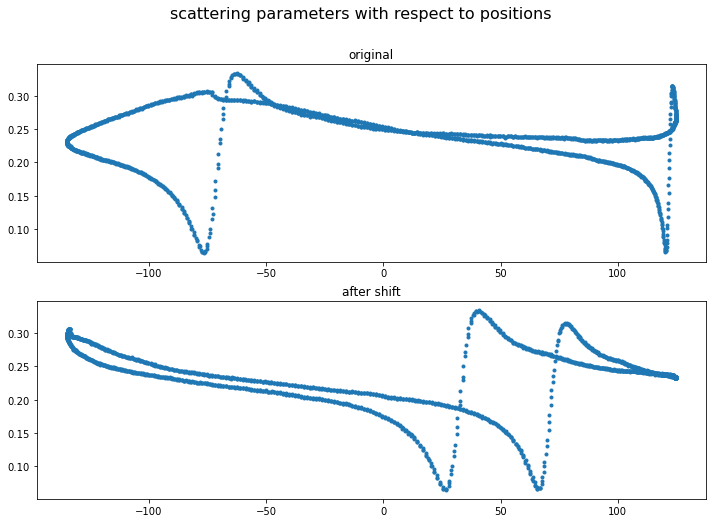

In [124]:
%matplotlib inline
plot_p_s(pos,pos_shift_pvptolvl,s21)

# Test Field

In [ ]:
for i in range(11):
    F = Fs[i]+max_sep[i][0]
    L = Fs[i]+max_sep[i][-1]
    pos = h51['pos1'][F:L]
    s21 = abs(h51['S21_P1_LEM1'][F:L,fidx])
    pos_shift = h51['pos1'][F + shift_lvl[i] : L + shift_lvl[i]]
    pos = pos_low[Fs()]